# First data exploration
in this file I'm going to explore the data. By doing:
- Define your labels/response in a categorical manner (high response, low response, late response,..) based on the behaviour of the antibody titers of these individuals. This is what is usually done, or you can keep the antibodies as numbers and try and predict the numerical value.
- Not do much feature engineering and focus to first see what a couple of methodologies can predict as a starter
- Group the features based on coexpression/do a first dimensionality reduction (PCA) and group features based on the biplot of the PCA.
- You can look up what some of these features mean and maybe use your findings to guide your way of combining them but I would keep a data driven approach
- Since you still have more than one dataset you could look at different ways of combining the information, either at the start or by building separate models for each dataset
- You will have to keep in mind that:
  - you have to somehow encode multiple features into a single feature
  - deal with low number of samples also in the way you evaluate the models
  - define the feature contributions at all steps as explainability is a big component of this kind of work
  - There may be missing values to deal with

### loading all datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from helper_functions.helper import model_with_shap
import shap
import umap

In [2]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/abtiters.csv')

# Load the cytokines data
cytokines = pd.read_csv('../data/cytokines_data.csv')

# Load the cyto data
cyto = pd.read_csv('../data/cyto_data.csv')

In [3]:
# Display the first few rows of each dataset
print("Abutters (antibody titers) dataset:")
print(abtiters.head())

print("\nCytokines dataset:")
print(cytokines.head())

print("\nCyto dataset:")
print(cyto.head())

Abutters (antibody titers) dataset:
        vaccine Vaccinee  Day 0  Day 21
0  Anti-Measles       M1    5.0   226.0
1  Anti-Measles      M11   10.9    24.2
2  Anti-Measles      M12  300.0   300.0
3  Anti-Measles      M13  176.0   300.0
4  Anti-Measles      M14   16.4   300.0

Cytokines dataset:
  Vaccinee  CMV.Status  EBV.Status  HSV1_2.Status  HHV6.Status     EGF  \
0       M1           1           1              0            0  278.88   
1       M2           1           1              0            0  238.38   
2       M3           0           1              0            1   96.75   
3       M4           0           0              0            1  376.30   
4       M5           0           1              0            1  245.51   

    FGF-2  Eotaxin  TGF-a   GCSF  ...   IL-6   IL-7   IL-8   IP-10   MCP-1  \
0  497.14   189.07  26.77  20.26  ...  19.40  14.77  57.72  111.55  379.73   
1   33.20   206.11   2.09   2.36  ...   1.99   2.47  18.02  113.51  539.30   
2  166.84    96.33   2.09

###### Antibody Titers Dataset:
| Column Name | Description |
| --- | --- | 
| vaccine | The type of vaccine administered to the individual (e.g., Anti-Measles). |
| Vaccinee | The identifier for the individual receiving the vaccine (e.g., M1, M11). |
| Day 0 | The measured antibody titer on Day 0, which is typically the baseline measurement before vaccination. |
| Day 21 | The measured antibody titer on Day 21, indicating the antibody response after vaccination. (could be an important signal for how well the individual responded to the vaccine.) |


###### Cytokines Dataset:
| Column Name | Description |
| --- | --- | 
| Vaccinee | Identifier for the individual (should match with the Vaccinee field in the Antibody Titers dataset). |
| CMV.Status | Cytomegalovirus infection status (binary: 1 = positive, 0 = negative). |
| EBV.Status | Epstein-Barr Virus infection status (binary: 1 = positive, 0 = negative). |
| HSV1_2.Status	| Herpes Simplex Virus (types 1 and 2) infection status (binary). |
| HHV6.Status | Human Herpesvirus 6 infection status (binary). |
| EGF | Measured concentration of Epidermal Growth Factor (EGF) in the blood. |
| FGF-2	| Fibroblast Growth Factor-2 concentration. |
| Eotaxin | A cytokine responsible for eosinophil recruitment. |
| TGF-a | Transforming Growth Factor-alpha concentration. |
| GCSF | Granulocyte Colony-Stimulating Factor concentration, which promotes the growth of white blood cells. |
| ... | .	Other columns represent various cytokines and their concentrations, including inflammatory and immune response markers like IL-6, TNFa, VEGF, etc. |

###### Cyto Dataset:
| Column Name | Description |
|-------------| --- | 
| Vaccinee    |	Identifier for the individual (should match with the Vaccinee field in the Antibody Titers dataset).|
| WBC         |	White Blood Cells count, important for the immune system's ability to fight infections.|
| RBC	        | Red Blood Cells count, responsible for carrying oxygen throughout the body.|
| HGB	        | Hemoglobin level, the protein in RBCs that carries oxygen to tissues.|
| HCT	        | Hematocrit, the percentage of blood composed of red blood cells.|
| PLT	        | Platelets count, crucial for blood clotting and preventing excessive bleeding.|
| %LYM        |	Percentage of lymphocytes in total WBC, important in the adaptive immune response.|
| %MON        |	Percentage of monocytes in total WBC, involved in removing dead cells and fighting certain infections.|
| %GRA        |	Percentage of granulocytes in total WBC, essential for fighting bacterial infections and inflammation.|

In [4]:
# Check for missing values and data types
print("\nAbutters missing values and data types:")
print(abtiters.info())

print("\nCytokines missing values and data types:")
print(cytokines.info())

print("\nCyto missing values and data types:")
print(cyto.info()) # there are some missing values

# Drop non-numeric columns
cyto_non_numeric = cyto[['Vaccinee']]
cyto_numeric = cyto.select_dtypes(include=[float, int])

# Use the 5 nearest neighbors to fill in the missing values
imputer = KNNImputer(n_neighbors=5)
cyto_filled = imputer.fit_transform(cyto_numeric)

# Convert the result back into a DataFrame with the original column names
cyto_filled_df = pd.DataFrame(cyto_filled, columns=cyto_numeric.columns)
cyto_final = pd.concat([cyto_non_numeric.reset_index(drop=True), cyto_filled_df], axis=1)


Abutters missing values and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   vaccine   40 non-null     object 
 1   Vaccinee  40 non-null     object 
 2   Day 0     40 non-null     float64
 3   Day 21    40 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.4+ KB
None

Cytokines missing values and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Vaccinee       40 non-null     object 
 1   CMV.Status     40 non-null     int64  
 2   EBV.Status     40 non-null     int64  
 3   HSV1_2.Status  40 non-null     int64  
 4   HHV6.Status    40 non-null     int64  
 5   EGF            40 non-null     float64
 6   FGF-2          40 non-null     float64
 7   Eotaxin        40 no

### playing around with the data

##### 1 - Decide on target labels


Abutters dataset with titer response:
  Vaccinee  Day 0  Day 21  titer_response
0       M1    5.0   226.0           221.0
1      M11   10.9    24.2            13.3
2      M12  300.0   300.0             0.0
3      M13  176.0   300.0           124.0
4      M14   16.4   300.0           283.6


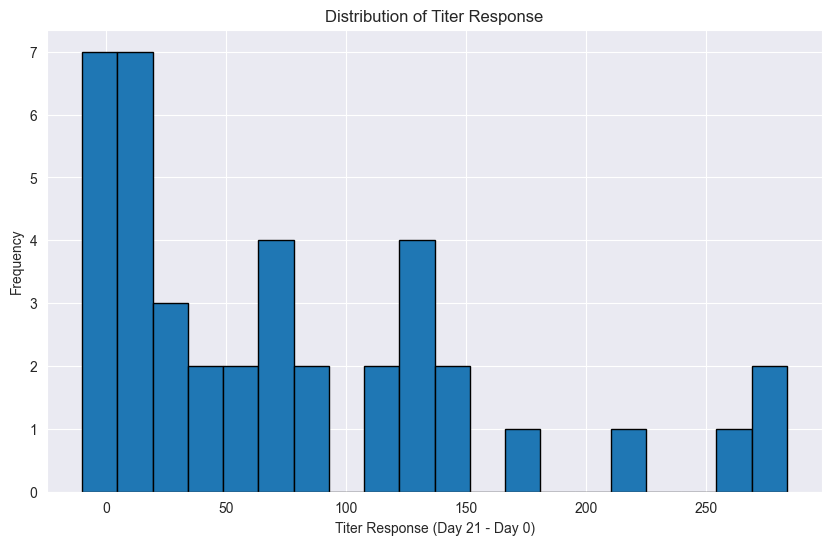


Abutters dataset with response labels:
  Vaccinee  titer_response response_label
0       M1           221.0           high
1      M11            13.3            low
2      M12             0.0            low
3      M13           124.0           high
4      M14           283.6           high

Frequency of responses:
response_label
low     27
high    13
Name: count, dtype: int64


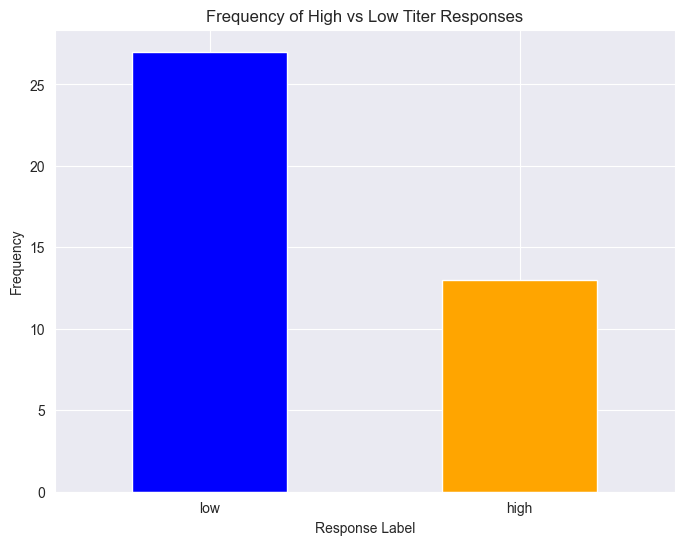

In [5]:
# Calculate the difference between Day 21 and Day 0 antibody titers
abtiters['titer_response'] = abtiters['Day 21'] - abtiters['Day 0']

print("\nAbutters dataset with titer response:")
print(abtiters[['Vaccinee', 'Day 0', 'Day 21', 'titer_response']].head())

# Plot the distribution of titer_response
plt.figure(figsize=(10, 6))
plt.hist(abtiters['titer_response'], bins=20, edgecolor='black')
plt.title('Distribution of Titer Response')
plt.xlabel('Titer Response (Day 21 - Day 0)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Define a threshold for high vs. low response
threshold = 100  # I chose 100 based on the plot (a little trail and error)
abtiters['response_label'] = abtiters['titer_response'].apply(lambda x: 'high' if x > threshold else 'low')

print("\nAbutters dataset with response labels:")
print(abtiters[['Vaccinee', 'titer_response', 'response_label']].head())

# Count the frequency of each label
response_counts = abtiters['response_label'].value_counts()

print("\nFrequency of responses:")
print(response_counts)

# Plot the frequency of high vs. low responses as a bar plot
plt.figure(figsize=(8, 6))
response_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Frequency of High vs Low Titer Responses')
plt.xlabel('Response Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

##### 2 - Numerical Prediction (small test but not saying much because I used a very simple model)
i am also looking to see if i can predict the response category based only on the Cytokine data

Mean Squared Error: 3.248095527094853
    Actual   Predicted
19   282.2  284.734045
16     9.6    9.872567
15    74.2   74.430180
26   133.2  131.640792
4    283.6  279.484494
Mean Squared Error: 3.248095527094853
Mean Absolute Error: 1.1388961523930883
R-squared: 0.9997056344666622


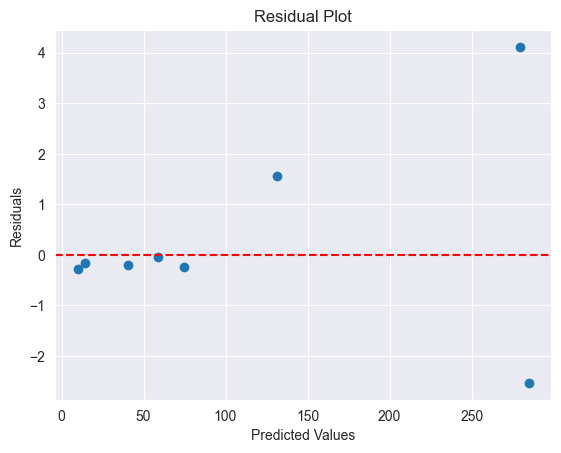

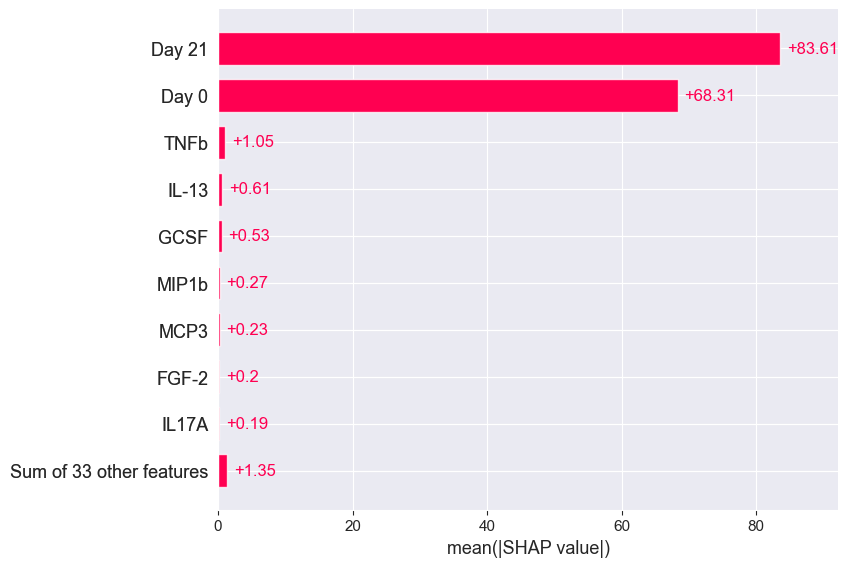

In [6]:
merged_data = pd.merge(abtiters, cytokines, on='Vaccinee')

# Drop non-numeric columns
X = merged_data.drop(columns=['titer_response', 'Vaccinee', 'response_label', 'vaccine'])

# Target variable
y = merged_data['titer_response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display the first few predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Residual analysis (using y_test - y_pred)
residuals = y_test - y_pred

# Scatter plot of predicted vs residuals
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

### SHAP Analysis ###
# SHAP values for the Linear Regression model
explainer = shap.Explainer(regressor, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot (Feature Importance)
shap.plots.bar(shap_values)

these results are pretty logical since i try to predict a metric "titer_response" that is calculated on Day 0 and Day 21. If i only train the model with these 2 parameters the model is near perfect because it just captures the calculation. let's see what removing Day 0 and Day 21 does. (we get even better results not including the rest of the data but only the Day 0 and Day 21 so the model just captures the math behind it)

Mean Squared Error: 3558866.072697993
    Actual    Predicted
19   282.2  3300.718108
16     9.6   135.357783
15    74.2   166.656322
26   133.2 -1060.459171
4    283.6 -3941.567353
Mean Squared Error: 3558866.072697993
Mean Absolute Error: 1129.289905559687
R-squared: -321.5297719321468


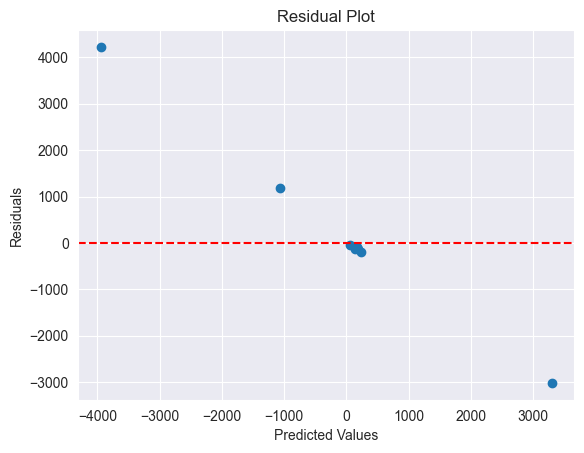

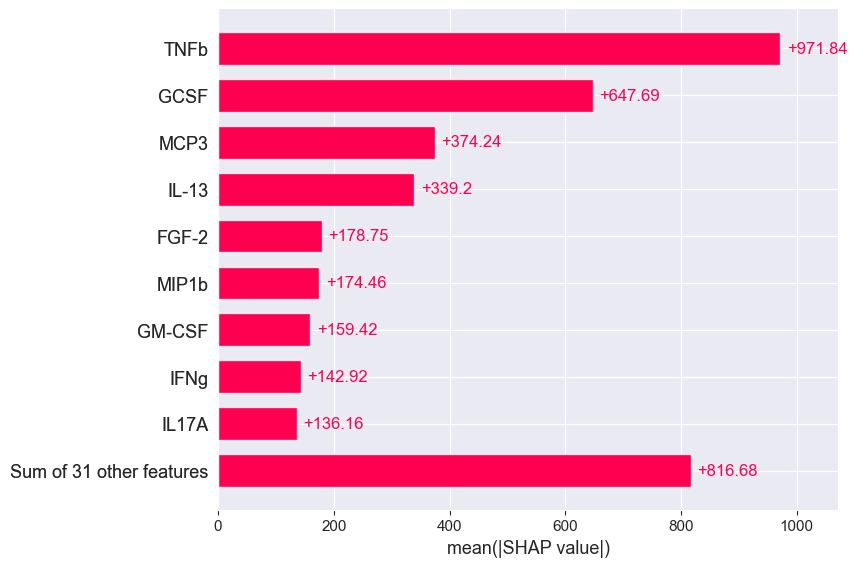

In [7]:
# Drop non-numeric columns
X = merged_data.drop(columns=['Day 0', 'Day 21', 'titer_response', 'Vaccinee', 'response_label', 'vaccine'])

# Target variable
y = merged_data['titer_response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display the first few predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Residual analysis (using y_test - y_pred)
residuals = y_test - y_pred

# Scatter plot of predicted vs residuals
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

### SHAP Analysis ###
# SHAP values for the Linear Regression model
explainer = shap.Explainer(regressor, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot (Feature Importance)
shap.plots.bar(shap_values)


Okay the very badd results with a linear model suggests that a linear model may not be appropriate for this dataset, especially given the complexity of immune responses and cytokine interactions. The large errors for some predictions (like predicting 3300 instead of 282.2) suggest that the model is struggling to fit the data well, possibly due to outliers or high variability in the cytokine levels. I'm going to see what results i become when i have a non-linear model like a RandomForestClassifier. And i'm going to predict the category ('high' or 'low')